In [1]:
import cv2
import matplotlib.pyplot as plt
import math

import numpy as np

import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn

from torchvision.models import VisionTransformer
from torchvision.models.vision_transformer import Encoder
from functools import partial
from typing import Any, Callable, Dict, List, NamedTuple, Optional
from torch.nn.utils.rnn import pad_sequence

import os
import pandas as pd
from pandas import isnull
from skimage import io, color, transform
from torch.utils.data import Dataset, DataLoader

import tqdm.notebook as tqdm
import time

import csv

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
class BoxesDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.boxes_frame = pd.read_csv(csv_file, header=None, sep='\r')
        self.boxes_frame[["im_name", "boxes"]] = self.boxes_frame.iloc[:,0].str.split(',', n=1, expand=True)
        self.boxes_frame = self.boxes_frame.drop(0, axis=1)
        self.boxes_frame["boxes"] = self.boxes_frame["boxes"].fillna("0,0,63,63")
        self.boxes_frame["boxes"] = self.boxes_frame["boxes"].str.split(',')
        self.boxes_frame["im_name"] = self.boxes_frame["im_name"].str.replace('\\', '/')
        self.boxes_frame = self.boxes_frame.drop_duplicates('im_name')

    def __len__(self):
        return len(self.boxes_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.boxes_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if len(image.shape) == 2:
            image = color.gray2rgb(image)
        boxes = self.boxes_frame.iloc[idx, 1]
        boxes = np.array(boxes, dtype=int).reshape(-1, 4)

        sample = {'image': image, 'boxes': boxes}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
bpath = './tiny-imagenet-200/train/boxes.csv'

(100000, 2)
0 (64, 64, 3) (4, 4)
1 (64, 64, 3) (5, 4)
2 (64, 64, 3) (4, 4)
3 (64, 64, 3) (2, 4)


C:\Users\Maria\AppData\Local\Temp\ipykernel_17272\1438306005.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.boxes_frame["im_name"] = self.boxes_frame["im_name"].str.replace('\\', '/')


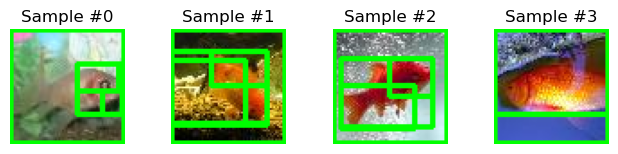

In [5]:
bdataset = BoxesDataset(csv_file=bpath,
                        root_dir='./')

fig = plt.figure()


for i, sample in enumerate(bdataset):
    print(i, sample['image'].shape, sample['boxes'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    im_out = sample['image'].copy()
    for (x, y, w, h) in sample['boxes']:
        cv2.rectangle(im_out, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(im_out)
    if i == 3:
        break


In [7]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w)).astype(np.float32)

        # h and w are swapped for boxes because for images,
        # x and y axes are axis 1 and 0 respectively
        boxes = np.array(boxes * [new_w / w, new_h / h, new_w / w, new_h / h], dtype=int)

        return {'image': img, 'boxes': boxes}

In [8]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h + 1)
        left = np.random.randint(0, w - new_w + 1)

        image = image[top: top + new_h,
                      left: left + new_w]

        #delete invisible boxes
        del_rows = np.where((boxes[:,0] + boxes[:,2] < left) | (boxes[:,0] > left + new_w) |
                            (boxes[:,1] + boxes[:,3] < top) | (boxes[:,1] > top + new_h))
        boxes = np.delete(boxes, del_rows, axis=0)

        #check left bound
        boxes[:, 2] = np.where(boxes[:,0] < left, boxes[:, 2] - left + boxes[:, 0], boxes[:, 2])
        boxes[:, 0] = np.where(boxes[:,0] < left, 0, boxes[:, 0] - left)

        #check top bound
        boxes[:, 3] = np.where(boxes[:,1] < top, boxes[:, 3] - top + boxes[:, 1], boxes[:, 3])
        boxes[:, 1] = np.where(boxes[:,1] < top, 0, boxes[:, 1] - top)

        #check right bound
        boxes[:, 2] = np.where(boxes[:,2] + boxes[:,0] > new_w, new_w - boxes[:, 0] - 1, boxes[:, 2])

        #check bottom bound
        boxes[:, 3] = np.where(boxes[:,3] + boxes[:,1] > new_h, new_h - boxes[:, 1] - 1, boxes[:, 3])

        return {'image': image, 'boxes': boxes}

In [9]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        image = image[:,::-1, :]
        boxes[:,0] = image.shape[1] - boxes[:,0] - boxes[:, 2]

        return {'image': image, 'boxes': boxes}

In [10]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image':norm(image), 'boxes':boxes}

In [11]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, boxes = sample['image'], sample['boxes']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'boxes': torch.from_numpy(boxes)}

In [13]:
transform_train = transforms.Compose([RandomHorizontalFlip(),
                            Rescale((180, 180)),
                            #Rescale((224, 224)),
                            RandomCrop(160),
                            ToTensor(),
                            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [14]:
transformed_dataset = BoxesDataset(csv_file=bpath,
                                           root_dir='./',
                                           transform=transform_train)

(100000, 2)


C:\Users\Maria\AppData\Local\Temp\ipykernel_17272\1438306005.py:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  self.boxes_frame["im_name"] = self.boxes_frame["im_name"].str.replace('\\', '/')


In [15]:
class MaskedEncoder(Encoder):
    def __init__(
        self,
        seq_length: int,
        num_layers: int,
        num_heads: int,
        hidden_dim: int,
        mlp_dim: int,
        dropout: float,
        attention_dropout: float,
        norm_layer: Callable[..., torch.nn.Module] = partial(nn.LayerNorm, eps=1e-6),
    ):
        super().__init__(
            seq_length=seq_length,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            mlp_dim=mlp_dim,
            dropout=dropout,
            attention_dropout=attention_dropout,
            norm_layer=norm_layer
        )

    def masked_forward(self, input: torch.Tensor):
        torch._assert(input.dim() == 3, f"Expected (batch_size, seq_length, hidden_dim) got {input.shape}")
        return self.ln(self.layers(self.dropout(input)))


In [16]:
class MaskedAutoEncoder(VisionTransformer):
    def __init__(
        self,
        image_size=160,
        in_chans=3,
        patch_size=16,
        num_layers=12,
        num_heads=12,
        hidden_dim=768,
        mlp_dim=3072,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        decoder_mlp_dim=2048,
        norm_layer=nn.LayerNorm
        ):
        #encoder params
        super().__init__(
            image_size=image_size,
            patch_size=patch_size,
            num_layers=num_layers,
            num_heads=num_heads,
            hidden_dim=hidden_dim,
            mlp_dim=mlp_dim,
            norm_layer=norm_layer
        )
        self.encoder = MaskedEncoder(
            self.seq_length,
            num_layers,
            num_heads,
            hidden_dim,
            mlp_dim,
            self.dropout,
            self.attention_dropout,
            norm_layer
        )
        self.norm = self.norm_layer(hidden_dim)

        #decoder params
        self.decoder_embed = nn.Linear(hidden_dim, decoder_embed_dim, bias=True)
        self.mask_token = nn.Parameter(torch.empty(1, 1, decoder_embed_dim).normal_(std=0.02))
        self.decoder = Encoder(
            self.seq_length,
            decoder_depth,
            decoder_num_heads,
            decoder_embed_dim,
            decoder_mlp_dim,
            self.dropout,
            self.attention_dropout,
            norm_layer
        )
        self.decoder_norm = self.norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True)

        #init weights
        torch.nn.init.normal_(self.class_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)


    def mask_process_input(self, x: torch.Tensor, boxes: torch.Tensor) -> torch.Tensor:
        n, c, h, w = x.shape
        p = self.patch_size
        torch._assert(h == self.image_size, f"Wrong image height! Expected {self.image_size} but got {h}!")
        torch._assert(w == self.image_size, f"Wrong image width! Expected {self.image_size} but got {w}!")
        n_h = h // p
        n_w = w // p

        # (n, c, h, w) -> (n, hidden_dim, n_h, n_w)
        x = self.conv_proj(x)
        # (n, hidden_dim, n_h, n_w) -> (n, hidden_dim, (n_h * n_w))
        x = x.reshape(n, self.hidden_dim, n_h * n_w)

        # (n, hidden_dim, (n_h * n_w)) -> (n, (n_h * n_w), hidden_dim)
        # The self attention layer expects inputs in the format (N, S, E)
        # where S is the source sequence length, N is the batch size, E is the
        # embedding dimension
        x = x.permute(0, 2, 1)
        #print(boxes)

        boxes[:,:,2] = (boxes[:,:,0] + boxes[:,:,2]) // p + 1 * (boxes[:,:,2] > 0)
        boxes[:,:,3] = (boxes[:,:,1] + boxes[:,:,3]) // p + 1 * (boxes[:,:,3] > 0)
        boxes[:,:,0] = boxes[:,:,0] // p
        boxes[:,:,1] = boxes[:,:,1] // p

        patch_boxes = torch.zeros(n, n_w, n_h)

        for sample in range(n):
            for box in range(boxes.shape[1]):
                l = boxes[sample, box, 0]
                r = boxes[sample, box, 2]
                t = boxes[sample, box, 1]
                b = boxes[sample, box, 3]
                patch_boxes[sample, l : r, t : b] = torch.add(patch_boxes[sample, l : r, t : b], 1)

        patch_boxes = torch.transpose(patch_boxes, 1, 2).reshape(n, n_h * n_w)


        return x, patch_boxes

    def mask_im(self, x, mask_ratio, boxes):
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)  # noise in [0, 1]
        
        #boxes weights in [0, 1]:
        # normalization by image
        #bweights = torch.div(1.*(boxes - torch.min(boxes, dim=1).values[:, None]),
        #                     (torch.max(boxes, dim=1).values - torch.min(boxes, dim=1).values + 1e-6)[:,None]).to(x.device)
        # normalization by batch
        bweights = torch.div(1.*(boxes - torch.min(boxes)), torch.max(boxes) - torch.min(boxes)).to(x.device)
        
        alpha = 0.6
        probs = alpha * bweights + (1 - alpha) * noise
        
        # sort probs for each sample
        ids_shuffle = torch.argsort(probs, dim=1, descending=True) # descend: large is keep, small is remove
        ids_restore = torch.argsort(ids_shuffle, dim=1)
        
        ids_keep = ids_shuffle[:, :len_keep]
        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        mask[:, :len_keep] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)
        return x_masked, mask, ids_restore
        
        

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_size
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_size
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs


    def encoder_forward(self, sample, mask_ratio):
        x = sample[0]
        boxes = sample[1]
        x, boxes = self.mask_process_input(x, boxes)
        n = x.shape[0]

        x = x + self.encoder.pos_embedding[:, 1:, :]

        x, mask, ids_restore = self.mask_im(x, mask_ratio, boxes)

        cls_token = self.class_token + self.encoder.pos_embedding[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x = self.encoder.masked_forward(x)

        x = self.norm(x)
        return x, mask, ids_restore


    def decoder_forward(self, x, ids_restore):
        x = self.decoder_embed(x)

        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))
        x = torch.cat([x[:, :1, :], x_], dim=1)

        x = self.decoder(x)
        x = self.decoder_norm(x)

        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove,
        """
        target = self.patchify(imgs)

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, sample, mask_ratio):
        x, mask, ids_restore = self.encoder_forward(sample, mask_ratio)
        pred = self.decoder_forward(x, ids_restore)
        loss = self.forward_loss(sample[0], pred, mask)
        return pred, mask, loss

In [17]:
def collate_fn(batch):
    images = [sample['image'] for sample in batch]
    boxes = [sample['boxes'] for sample in batch]
    boxes_padded = pad_sequence(boxes, batch_first=True, padding_value=0)
    return torch.stack(images), boxes_padded

In [18]:
dataloader = DataLoader(transformed_dataset, batch_size=32,
                        shuffle=True, collate_fn=collate_fn, num_workers=0)

In [23]:
tmean, tstd = transform_train.transforms[4].mean, transform_train.transforms[4].std
tmean, tstd = np.array(tmean), np.array(tstd)

inverse_transform = torchvision.transforms.Compose([
    torchvision.transforms.Normalize(
        mean=-tmean / tstd,
        std=1.0 / tstd
    ),
    torchvision.transforms.ToPILImage()
])

In [24]:
def training_loop(n_epochs, model, mask_ratio, optimizer, dl_train, device):
    train_losses = []
    pbar = tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)
    for epoch in pbar:
        model.train(True)

        total_train = len(dl_train)
        train_loss = 0.
        for images, boxes in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            images, boxes = images.to(device), boxes.to(device)
            optimizer.zero_grad()
            pred, mask, loss = model((images, boxes), mask_ratio)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        train_losses.append(train_loss/total_train)

        if epoch % 3 == 0 or epoch == n_epochs - 1 or epoch < 5:
            model.eval()

            with torch.no_grad():              
                tr_im, tr_b = next(iter(dl_train))

                fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))
                ax[0].imshow(inverse_transform(tr_im[0]))
                ax[0].set_title(f"Original: {epoch:03d}")
                
                b_arr = np.array(inverse_transform(tr_im[0]))
                for (x, y, w, h) in tr_b[0]:  
                    x, y, w, h = x.item(), y.item(), w.item(), h.item()
                    cv2.rectangle(b_arr, (x, y), (x + w, y + h), (0, 255, 0), 2)
                ax[1].imshow(b_arr)
                ax[1].set_title(f"Boxes: {epoch:03d}")
                
                tr_im = tr_im.to(device)
                tr_b = tr_b.to(device)

                tr_out, _, _ = model((tr_im, tr_b), mask_ratio)
                tr_out = model.unpatchify(tr_out)
                ax[2].imshow(inverse_transform(tr_out[0].to("cpu")))
                ax[2].set_title(f"Reconstructed: {epoch:03d}")

                plt.show()
                plt.close()

            pbar.set_description(
                'Loss (Train): {0:.3f}\n'.format(
                    train_losses[-1]
                )
            )
            print('Loss (Train): {0:.3f}\n'.format(
                    train_losses[-1]
                ))

    return train_losses

In [25]:
n_epochs = 22

In [26]:
MASK_RATIO=0.8

In [27]:
mae = MaskedAutoEncoder()
mae.to(device)

MaskedAutoEncoder(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): MaskedEncoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (

In [29]:
optimizer = torch.optim.Adam(mae.parameters(), lr=0.0001)

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

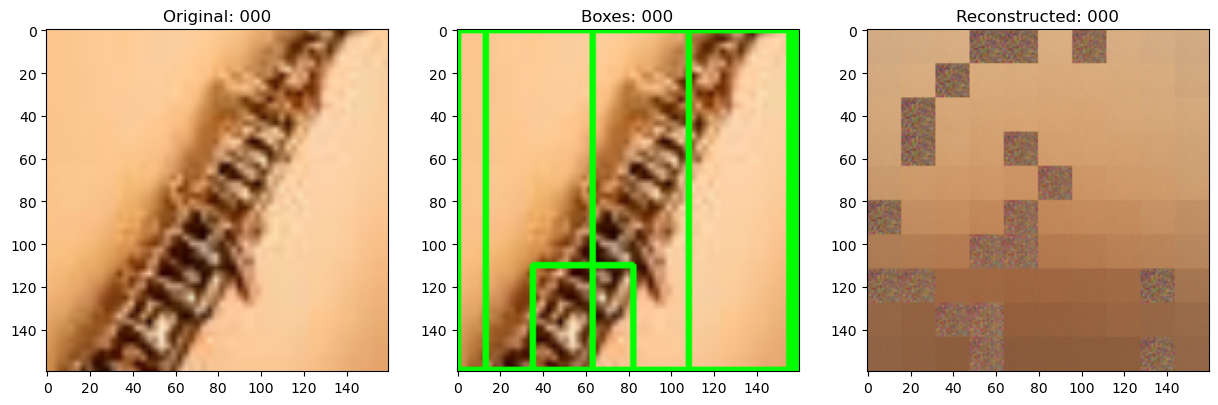

Loss (Train): 0.998



  0%|          | 0/3125 [00:00<?, ?it/s]

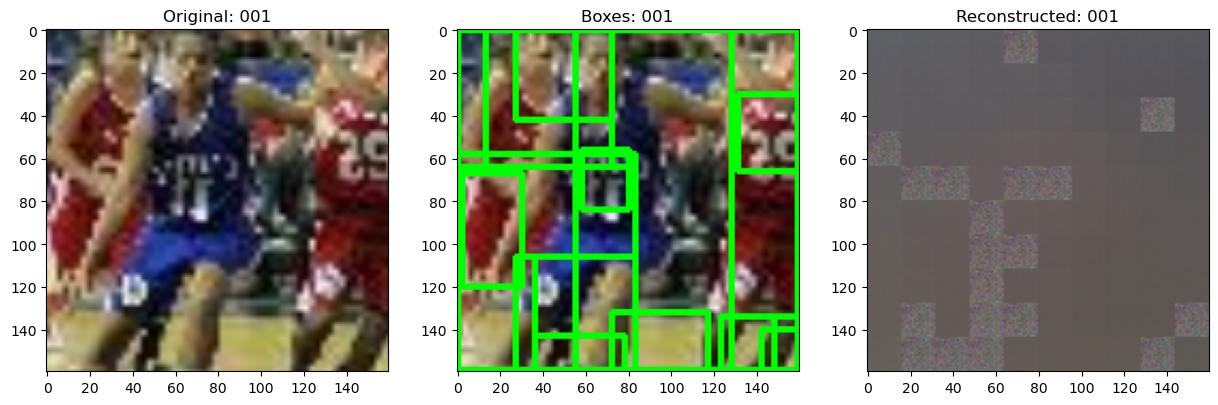

Loss (Train): 0.957



  0%|          | 0/3125 [00:00<?, ?it/s]

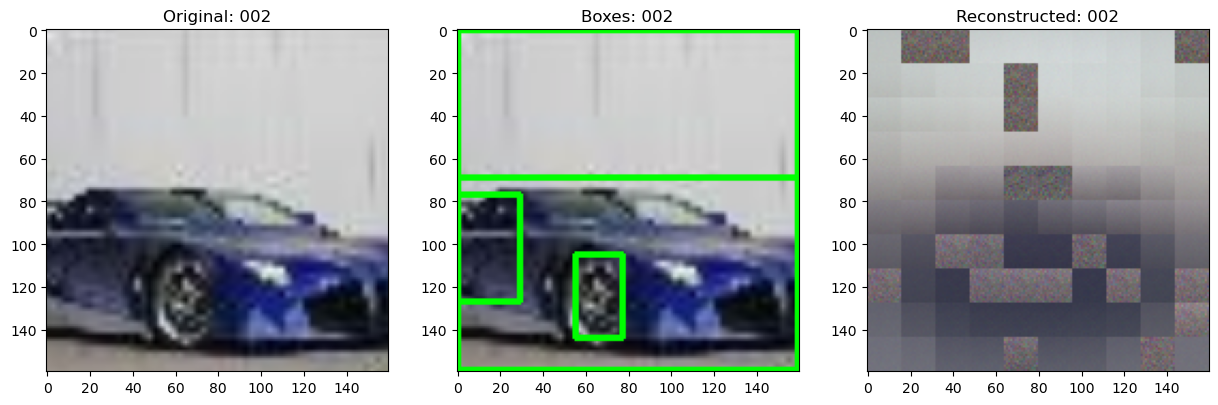

Loss (Train): 0.886



  0%|          | 0/3125 [00:00<?, ?it/s]

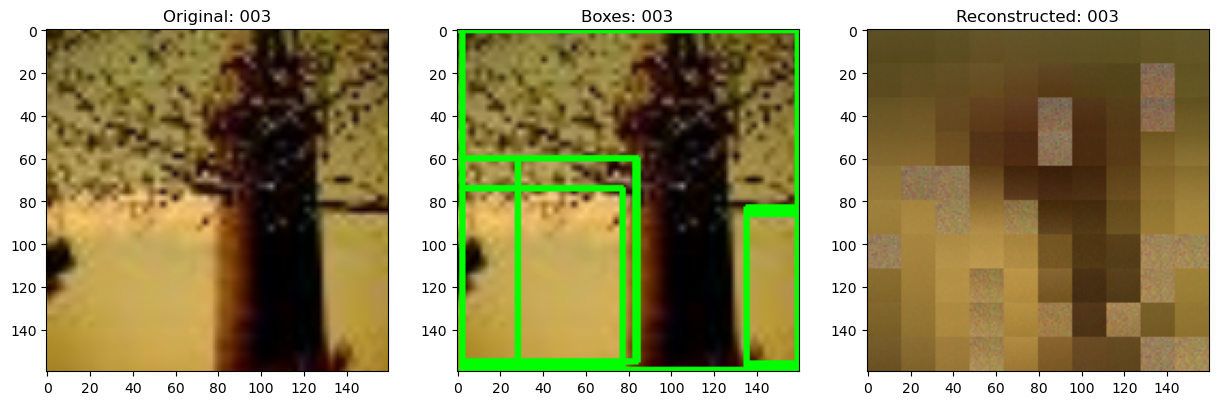

Loss (Train): 0.800



  0%|          | 0/3125 [00:00<?, ?it/s]

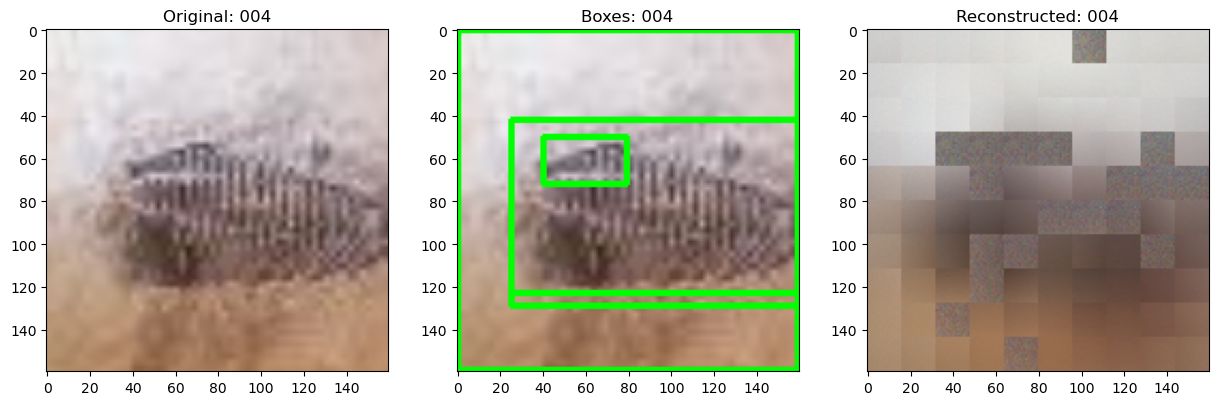

Loss (Train): 0.705



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

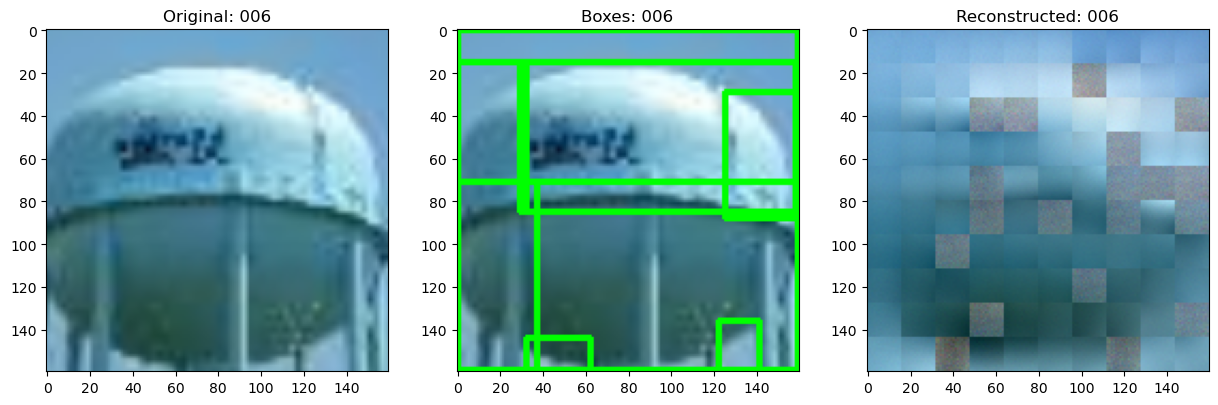

Loss (Train): 0.552



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

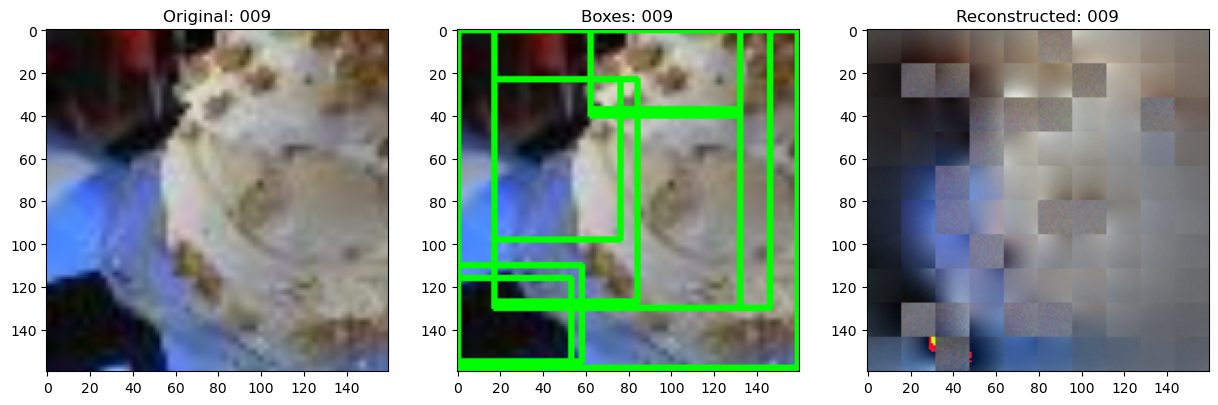

Loss (Train): 0.509



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

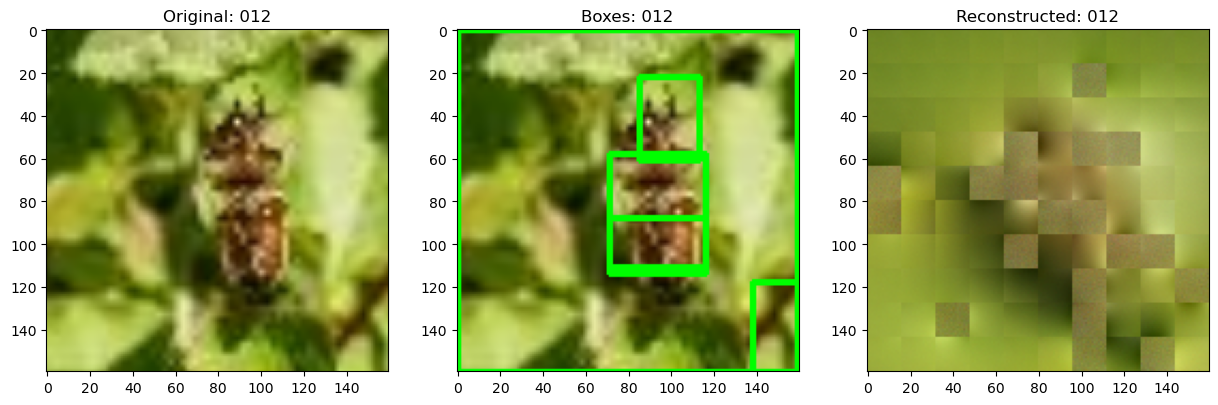

Loss (Train): 0.488



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

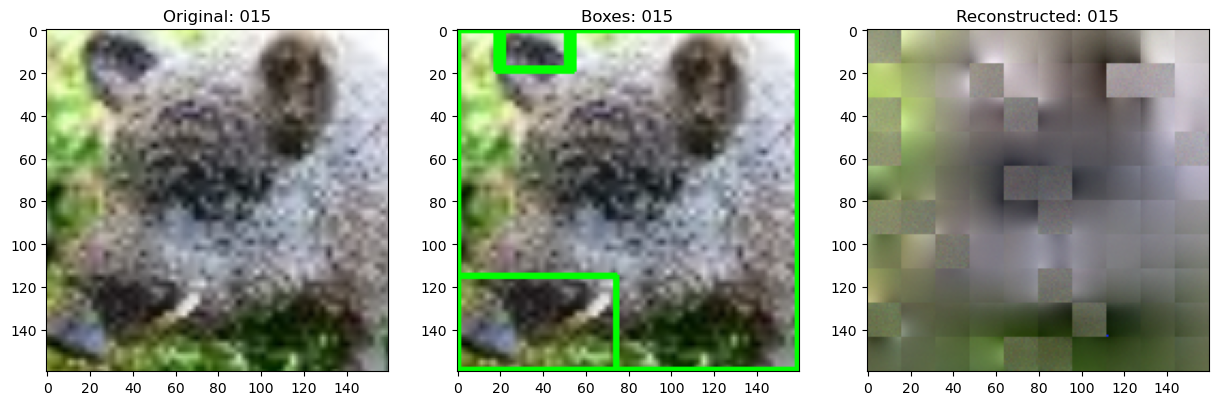

Loss (Train): 0.478



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

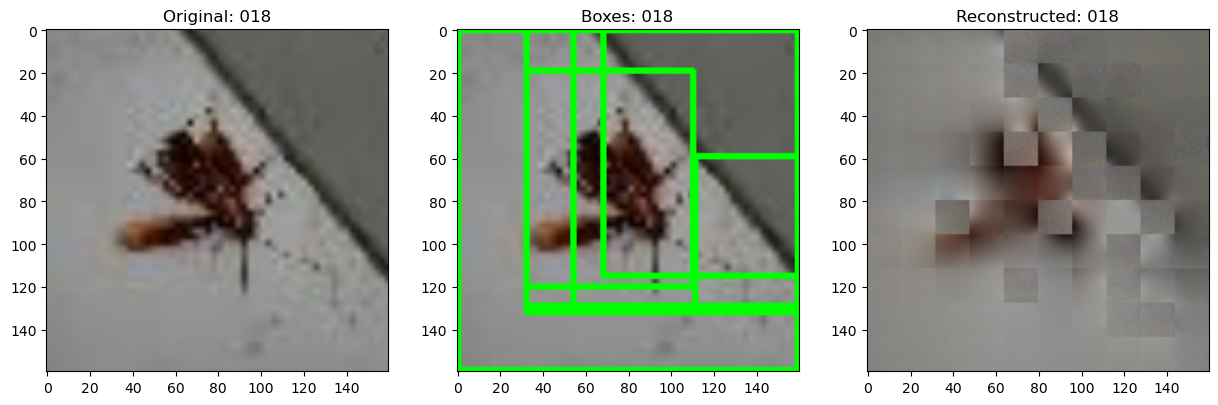

Loss (Train): 0.470



  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

  0%|          | 0/3125 [00:00<?, ?it/s]

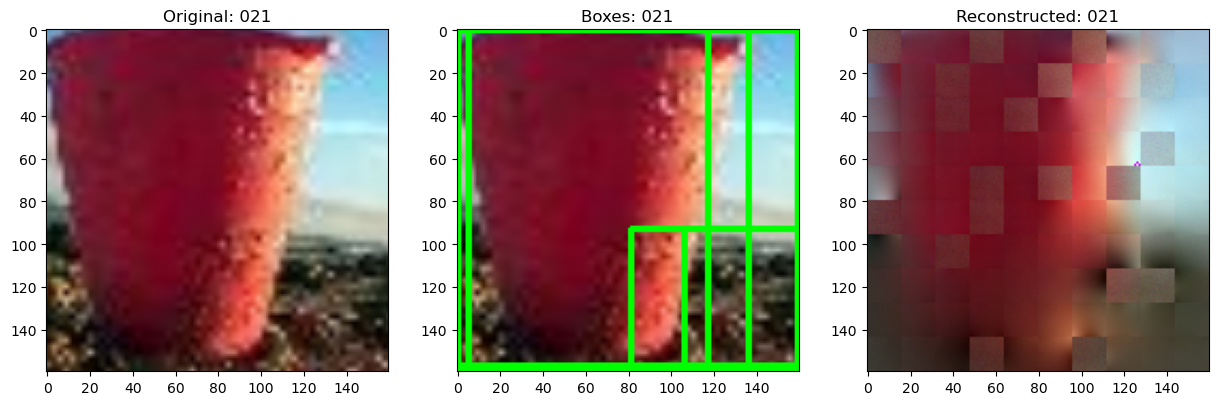

Loss (Train): 0.463



In [30]:
if __name__ == "__main__":
    torch.backends.cudnn.benchmark=True
    train_losses = training_loop(
            n_epochs=n_epochs, 
            model=mae,
            mask_ratio=MASK_RATIO,
            optimizer=optimizer, 
            dl_train=dataloader, 
            device=device
        )

In [34]:
state_dict = mae.state_dict()
weights_name = 'weights_22ep_minmax06_mr08_batchnorm.pt'
torch.save(state_dict, weights_name)

In [35]:
train_losses

[0.998441521987915,
 0.956731990776062,
 0.8863992413330078,
 0.8001109808158875,
 0.7045415960121155,
 0.588948618402481,
 0.5518339904308319,
 0.5333551504135132,
 0.5208235236644745,
 0.5085516492176055,
 0.5002784226989746,
 0.4926819649028778,
 0.48778612246513364,
 0.48396492603302,
 0.4807117395877838,
 0.4777853581047058,
 0.4733775927734375,
 0.47134422825813294,
 0.470254232339859,
 0.46687462368011473,
 0.46531815846443175,
 0.4625921012878418]